In [1]:
# Statistical Hypothesis Testing:
# Need to create hypothesis and test our assertions

# Example:
# This is a fair coin
# Data scientists prefer Ptython to R
# Null Hypothesis H0: default position
# H1: Alternate hypothesis to compare H0 to

# 1. fLIPPING A COIN
# a COIN AND WANT TO TEST IF ITS FAIR
# H0: Assumption that the coin has a prob p of landing heads
# Null Hypothesis - The coin is fair so p = 0.5
# H1: Alternate Hypothesis: p != 0.5

# We will test flipping the coin N times and counting the number of heads X
# Each coin flip is a Bernoulli trial
# so X is a Binomail(n,p) random variable we can approx using the normal distribution:

def normal_approx_to_binomail(n, p):
    
    """Finds mu and sigma corresponding to a Binomail(n,p)"""
    # Mean = probability * N (number of trials) = 0.5 * n
    mu = p * n
    # Standard Dev = sqrt of prob (Null H0) * (1-PROB) (H1:Alt Hypo) * N
    # sqrt(0.5 * (1-0.5) * n)
    sigma = math.sqrt(p * (1-p)*n)
    return mu, sigma
    

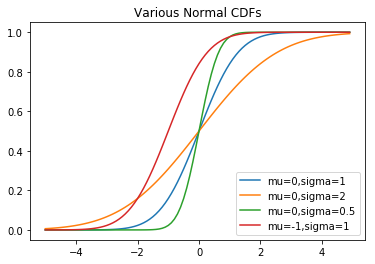

In [2]:
# Whenever a random variable follows a normal distribution we can use
# normal_cdf to figure out the probability that its realized value lies within or outside a particular interval:
import math
from matplotlib import pyplot as plt

# cdf: cumulative distribution function: represents the probability the variable is below a threshold:
# x: input point
# mu: MEAN
# sigma: standard deviation
def normal_cdf(x, mu=0, sigma=1):
    return (1 + math.erf((x-mu) / math.sqrt(2) / sigma)) / 2
    
    
# Plot soem example points of normal_cdf:
# Get example points:
xs = [x/10.0 for x in range(-50, 50)]
# Plot points run through normal_cdf:
plt.plot( xs, [normal_cdf(x, sigma=1) for x in xs], '-', label='mu=0,sigma=1' )
plt.plot( xs, [normal_cdf(x, sigma=2) for x in xs], '-', label='mu=0,sigma=2' )
plt.plot( xs, [normal_cdf(x, sigma=0.5) for x in xs], '-', label='mu=0,sigma=0.5' )
plt.plot( xs, [normal_cdf(x, mu=-1) for x in xs], '-', label='mu=-1,sigma=1' )
plt.legend(loc=4) # bottom right
plt.title("Various Normal CDFs")
plt.show()

# The normal_cdf is the probability the variable is below a threshold:
normal_probability_below = normal_cdf

# Check if its above the threhold
def normal_probability_above(lo, mu=0, sigma=1):
    return 1 - normal_cdf(lo, mu, sigma)

# Check if its between: less than hi, but not less than lo
def normal_probability_between(lo, hi, mu=0, sigma=1):
    # Range: High - Low
    return normal_cdf(hi, mu, sigma) - normal_cdf(lo, mu, sigma)

# outside:  not between
def normal_probability_outside(lo, hi, mu=0, sigma=1):
    return 1 - normal_probability_between(lo, hi, mu, sigma)

In [ ]:
# We can calculate the reverse as well:
# Finding the NONTAIL region or symettric interval (standard deviation) around the mean
# that accounts for a certain leve of likelihood:

# This function continues to narrow in on a Z thats close enough to the desired probability: 
# Resembles gradient descent
def inverse_normal_cdf(p, mu=0, sigma=1, tolerance=0.00001):
    """find approx inverse using binary search"""
    
    # if not standard, compute standard and rescale:
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    
    low_z, low_p = -10.0, 0 # normal_cdf(-10) is very close to 0
    hi_z, hi_p = 10.0, 1 # normal_cdf(10) is very close to 1
    
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2 # get the midpoint
        mid_p = normal_cdf(mid_z) # get the cdf's value at the midpoint
        
        if mid_p < p:
            # midpoint is still too low, search above it:
            low_z, low_p = mid_z, mid_p
            
        elif mid_p > p:
            # midpoint is still too high, search below it:
            hi_z, hi_p = mid_z, mid_p
        else:
            break
            
    return mid_z

# Example we want an interval around the mean containg 60$ probability then
# we can find the cutoffs where the upper and lower tails each contain 20% of the probability:

# Right hand side:
def normal_upper_bound(probability, mu=0, sigma=1):
    """Returns the z for which P(Z <= z) = probability"""
    return inverse_normal_cdf(probability, mu, sigma)

# Left hand side:
def normal_lower_bound(probability, mu=0, sigma=1):
    """Returns the z for which P(Z >= z) = probability"""
    return inverse_normal_cdf(1 - probability, mu, sigma)


def normal_two_sided_bounds(probability, mu=0, sigma=1):
    """Returns symetric around the mean taht contain the specified probability:"""
    tail_probability = (1 - probability) / 2
    
    # upper bound should have tail probability above it:
    upper_bound = normal_lower_bound(tail_probability, mu, sigma)
    
    # lower bound should have tail probability below it:
    lower_bound = normal_upper_bound(tail_probability, mu, sigma)
    
    return lower_bound, upper_bound

# Example: Flip a coin n = 1000 times
# Our hypothesis X should be distributed approximatelly normally with mean = 50 and stand dev = 15.8:

mu_0, sigma_0 = normal_approximation_to_binomial(1000, 0.5)

# We need to make a decision about significance:
# How willing to make a type 1 error - False Positive - where we reject H0 even though its true: 5%

# This test rejects the H0 if X falls outside the bounbds given:
normal_two_sided_bounds(0.95, mu_0, sigma_0) # (469, 531)

# Assuming p equals 0.5 (H0 is true) there is just a 5% chance we observe an X that lies outside this interval

# Type 2 error: We fail to reject H0 (p OF HEADS OR TAILS = 0.5) EVEN THOUGH IT IS FALSE
# h0 IS FALSE : P OF FLIP IS NOT 0.5

# Assume p of coin flip is 0.55 not 0.5:

# 95% bounds based on assumption p is 0.5
lo, hi = normal_two_sided_bounds(0.95, mu_0, sigma_0)

# actual mu and sigma based on p = 0.55:
mu_1, sigma_1 = normal_approximation_to_binomial(1000, 0.55)

# a type 2 error means we fail to reject the null hypothesis even though its false
# which will happen when X is still in our original interval:
type_2_probability = normal_probability_between(lo, hi, mu_1, sigma_1)
power = 1 - type_2_probability

# If we imagine instead that our null hypothesis was that the coin is not biased towards HEADS
# or that p <= 0.5
# In this case we want a one-sided test that rejects the null hypothesis when X is much larger than 50 
# BUT NOT WHEN X is smaller than 50
# A 5% significance test involves using normal_probability_below to find the cutoff 
# below which 95% of the probability lies:

hi = normal_upper_bound(0.95, mu_0, sigma_0)
# is 526 ( < 531, to get a probability in the upper tail: right hand sid eof the normal distribution)

